# Creating and excecuting MDF models

This is a quick introduction to building MDF graphs and using them in different scenarios.

1. **[Create a Model containing a Graph](#h1)**
2. **[Generate a graph image from the model](#h2)**
3. **[Execute the graph & print the output values](#h3)**


## 1. Create a [Model](https://mdf.readthedocs.io/en/latest/api/Specification.html#model) containing a [Graph](https://mdf.readthedocs.io/en/latest/api/Specification.html#graph) <a class="anchor" id="h1"></a>


In [1]:
from modeci_mdf.mdf import *

# Create a model containing one graph
mod = Model(id="AB")
mod_graph = Graph(id="ab_example")
mod.graphs.append(mod_graph)



### 1.1 Create the first [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [2]:
# Create a node
a_node = Node(id="A", metadata={"color": "0 .8 0"})

# Add a parameter with a specific value
a_node.parameters.append(Parameter(id="level", value=1.0))

# Add an output port
a_node.output_ports.append(OutputPort(id="output", value = "level"))

# Add node to the graph
mod_graph.nodes.append(a_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level



### 1.2 Create another [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [3]:
b_node = Node(id="B", metadata={"color": ".8 0 0"})
mod_graph.nodes.append(b_node)

# Add an input port
b_node.input_ports.append(InputPort(id="input"))

# Add some parameters
b_node.parameters.append(Parameter(id="slope", value=1.2))
b_node.parameters.append(Parameter(id="intercept", value=3))


# Add a parameter which used the internal parameter as well as the value from the input
p1 = Parameter(
    id="linear_func",
    value="input * slope + intercept",
)
b_node.parameters.append(p1)

# Add an output port
b_node.output_ports.append(OutputPort(id="output", value="linear_func"))


### 1.3 Create an  [Edge](https://mdf.readthedocs.io/en/latest/api/Specification.html#edge) between the [Nodes](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [4]:
# This helper method just adds an edge connecting the first output port of 
# the pre node to the first input port of the post node
from modeci_mdf.utils import simple_connect

e1 = simple_connect(a_node, b_node, mod_graph)

# Print the current structure
print(mod_graph.to_yaml())


ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                slope:
                    value: 1.2
                intercept:
                    value: 3
                linear_func:
                    value: input * slope + intercept
            output_ports:
                output:
                    value: linear_func
    edges:
        edge_A_B:
            sender: A
            receiver: B
            sender_port: output
            receiver_port: input



### 1.4 Save the model to file

The model can be saved to a file (serialized) in either JSON or YAML format.

In [5]:
mod.to_json_file("AB.json")
mod.to_yaml_file("AB.yaml")

modelspec >>> Written Model to: AB.json
modelspec >>> Written Model to: AB.yaml


'AB.yaml'

## 2. Generate a graph image from the model <a class="anchor" id="h2"></a>

We will use a method on the model to generate an image representing the structure of the graph.


Converting MDF graph: ab_example to graphviz (level: 3, format: png)
    Node: A
Converting 0 .8 0 to hex color
    Node: B
Converting .8 0 0 to hex color
    Edge: edge_A_B connects A to B
Written graph image to: AB.png


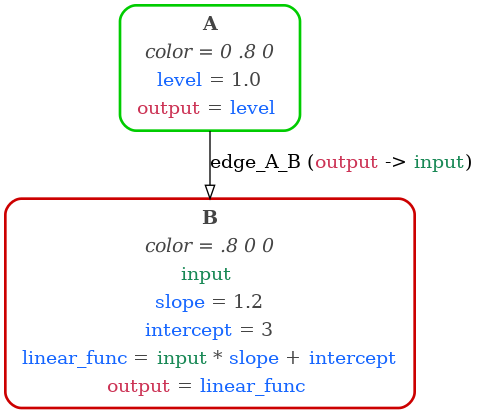

In [6]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="AB"
    )

from IPython.display import Image
Image(filename="AB.png")

## 3. Execute the graph & print the output values <a class="anchor" id="h3"></a>

The Graph is converted to an EvaluableGraph, which can be used to evaluate the current state of the graph's parameters. 

### 3.1 Execute the graph with the current parameter values 

In [7]:
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
eg.evaluate()

print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B: %s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)


Init graph: ab_example
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A: 1
Output of B: 4.2


### 3.2 Change a value to a Numpy array & execute the graph again

In [8]:
import numpy as np 
a_node.get_parameter('level').value = np.array([[1,2],[3,4]])

eg.evaluate()

print('Output of A:\n%s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B:\n%s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)

Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.2 5.4]
 [6.6 7.8]]


# Modifying above Examples

In [10]:
	def main():
    mod = Model(id="States")
    mod_graph = Graph(id="state_example")
    mod.graphs.append(mod_graph)

    #Counter node
    counter_node = Node(id="counter_node")

    p1 = Parameter(id="increment", value=1)
    counter_node.parameters.append(p1)

    p2 = Parameter(id="count", value="count + increment")
    counter_node.parameters.append(p2)

    op1 = OutputPort(id="out_port", value=p2.id)
    counter_node.output_ports.append(op1)

    mod_graph.nodes.append(counter_node)

    #Sine node
    sine_node = Node(id="sine_node")

    sine_node.parameters.append(Parameter(id="amp", value=3))
    sine_node.parameters.append(Parameter(id="period", value=0.4))

    s1 = Parameter(
        id="level", default_initial_value=0, time_derivative="distance/time"
    )
    sine_node.parameters.append(s1)

    s2 = Parameter(
        id="distance",
        default_initial_value=1,
        time_derivative="-1 * level/time",
    )
    sine_node.parameters.append(s2)

    op1 = OutputPort(id="out_port", value="amp * level")
    sine_node.output_ports.append(op1)

    mod_graph.nodes.append(sine_node)

    new_file = mod.to_json_file("%s.json" % mod.id)
    new_file = mod.to_yaml_file("%s.yaml" % mod.id)

    if "-run" in sys.argv:
        verbose = True
        # verbose = False
        from modeci_mdf.utils import load_mdf, print_summary

        from modeci_mdf.execution_engine import EvaluableGraph

        eg = EvaluableGraph(mod_graph, verbose)
        dt = 0.01

        duration = 2
        t = 0
        recorded = {}
        times = []
        s = []
        while t <= duration:
            times.append(t)
            print("======   Evaluating at t = %s  ======" % (t))
            if t == 0:
                eg.evaluate()  # replace with initialize?
            else:
                eg.evaluate(time_increment=dt)

            s.append(eg.enodes["sine_node"].evaluable_outputs["out_port"].curr_value)
            t += dt

        if "-nogui" not in sys.argv:
            import matplotlib.pyplot as plt

            plt.plot(times, s)
            plt.show()

    if "-graph" in sys.argv:
        mod.to_graph_image(
            engine="dot",
            output_format="png",
            view_on_render=False,
            level=3,
            filename_root="states",
            only_warn_on_fail=True,  # Makes sure test of this doesn't fail on Windows on GitHub Actions
        )

    return mod_graph